# Bayesian Scientific Computing and Probabilistic Programming: inside and outside the “black box” 

Bayesian methods are increasingly important in scientific computing where uncertainties and incomplete information play a role. This mini-tutorial will walk participants through the basic probabilistic concepts to give the understanding of how inverse problems and parameter estimation problems can be recast in the form of Bayesian inference, as well as equip them with hands-on tools for tackling such problems. The minitutorial will consist of two parts.


 

## Part I - [Daniela Calvetti](https://mathstats.case.edu/faculty/daniela-calvetti/), [Erkki Somersalo](https://mathstats.case.edu/faculty/erkki-somersalo/)
 
will begin with the explanation of the overarching Bayesian philosophy, followed by the fundamentals of modelling and computation.  Participants will be provided with basic programs in Matlab that will be tested on both static as well as  evolutionary time-dependent problems. By the end of this session participants will have overcome the fear of looking inside the “black box” of Bayesian inference and have laid a foundation for building their own Bayesian scientific computing codes.





## Part II - [Elizaveta Semenova](https://elizaveta-semenova.com/), [Maria han Veiga]()
will explain what probabilistic programming languages are in the modern landscape, and  demonstrate abilities of one of such easy-to-use software packages. This “black box” approach will equip participants with a tool allowing them to focus on the scientific problem of interest, while inference is being taken care of by the inference engine. We will show how to use Python libraries to perform exact Bayesian inference (using Markov Chain Monte Carlo technique) as well as approximate techniques (such as variational inference).

## Part II: probabilistic programming.

- Parameter inference (coin toss)
  - Explicitly
  - MCMC 

- Introduction to Pyro:   
  - Guides / models / etc
  - Revisiting the coin toss parameter inference (MCMC)
  - Variational inference
  - Bayesian Linear regression

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-darkgrid')

In [2]:
##############################################
# prior x likelihood = posterior
##############################################

# coin toss with unknown parameter param

def flip_coin(sucess, n_prev, n,param=0.2):
  for i in range(n):
    p = stats.bernoulli.rvs(param,size=1)
    if p == 1:
      sucess+=1
    else:
      sucess = sucess
  return sucess, n_prev+n

sucess, n = flip_coin(0,0,10)
print(sucess,n)

# define grid points
grid_points=100

# define grid
p_grid = np.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
likelihood = stats.binom.pmf(300, 600, p_grid)
prior1 = np.repeat(1, grid_points)

3 10


In [3]:
def computePosterior(likelihood, prior):
    
    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()
    
    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    plt.plot(p_grid, prior)

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    plt.plot(p_grid, likelihood)

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior)
    plt.show()
    
    return posterior

17 100


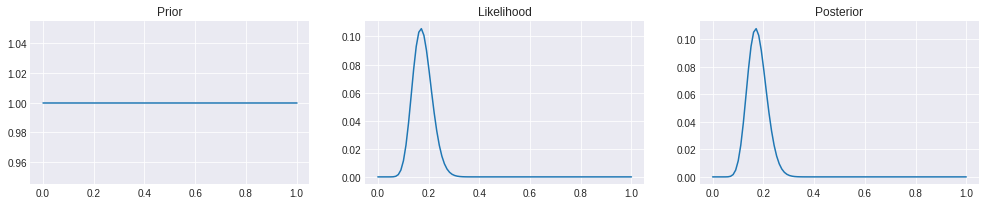

213 1100


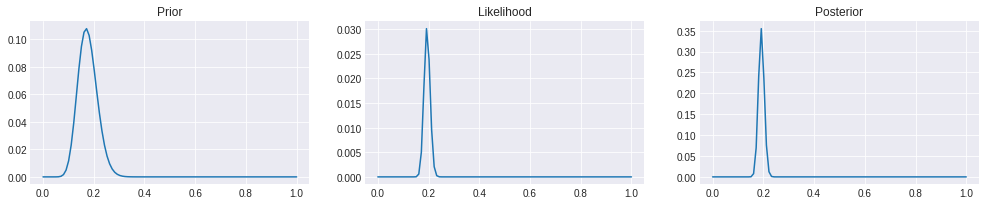

In [4]:
prior1 = np.repeat(1, grid_points)  
sucess, n = flip_coin(0,0,100)
print(sucess,n)
likelihood = stats.binom.pmf(sucess, n, p_grid)
posterior = computePosterior(likelihood, prior1)


sucess, n = flip_coin(sucess,100,1000)
print(sucess,n)
likelihood = stats.binom.pmf(sucess, n, p_grid)
posterior1 = computePosterior(likelihood, posterior)

In [5]:
prior2 = (p_grid >= 0.25).astype(int)
# different prior


In [6]:
prior3 = np.exp(- 5 * abs(p_grid - 0.5)) 
# different prior

We have now seen an example where we could calculate the posterior exactly. It is not always possible. Iterative algorithms exist, such as MCMC, to estimate the posterior numerically.

# MCMC Metropolis-Hastings 

Given a probability density $\pi$ called
the _target_, defined on a state space
$X$, and computable up to a multiplying constant, $\pi(x) \propto \tilde{\pi}(x)$, the __Metropolis–Hastings__ (1953,1970) algorithm, proposes a generic way to construct a Markov chain on $X$ that is ergodic and stationary with respect to $\pi$, meaning that, if $X(t) \sim \pi(x)$, then $X(t+1) \sim \pi(x)$ — and that therefore converges in distribution to $\pi$.

The main motivation for using Markov chains is that they provide shortcuts in cases where generic sampling requires too much effort from the experimenter. Markov chains construct a progressive picture of the target distribution, proceeding by local exploration of the state space $X$ until all the regions of interest have been uncovered.

## The algorithm

The Metropolis–Hastings algorithm
associated with a target density $\pi$ requires the choice of a conditional density $q$ also called proposal or candidate
kernel. The transition from the value
of the Markov chain $X(t)$ at time $t$
and its value at time $t + 1$ proceeds
via the following transition step:

1. Given $x=X(t)$
2. Generate $y_t= q(y|x) $  

3. $ X(t+1) = \begin{cases} 
      Y_t & \mbox{with probability} \quad  p \\
      x & \mbox{with probability}  \quad 1-p
   \end{cases} $

   where $p = min\left(\frac{\tilde{\pi}(y)}{\tilde{\pi}(x)} \frac{q(x|y)}{q(y|x)},1 \right)$


In [7]:
def target(likelihood, prior, n, h, parameter):
    if parameter < 0 or parameter > 1:
        return 0
    else:
        return likelihood(n, parameter).pmf(h)*prior.pdf(parameter)

In [8]:
h, n = flip_coin(0,0,100,param=0.3)
a = 10
b = 10
likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

In [9]:
naccept = 0
parameter = 0.1 # initial value for parameter
niters = 10000

samples = np.zeros(niters+1)
samples[0] = parameter

for i in range(niters):
    parameter_p = parameter + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, parameter_p)/target(likelihood, prior, n, h, parameter ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        parameter = parameter_p
    samples[i+1] = parameter

In [10]:
nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))

Portion of accepted steps = 0.1654


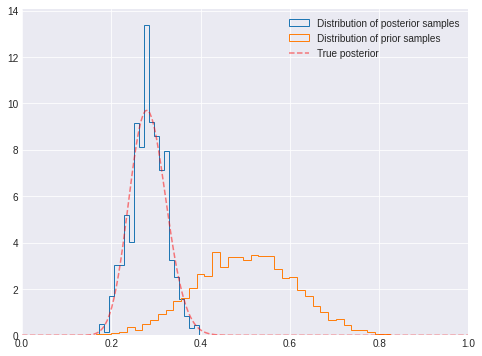

In [11]:
post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(8, 6))
plt.hist(samples[nmcmc:], 20, histtype='step', linewidth=1, label='Distribution of posterior samples', density=True);
plt.hist(prior.rvs(nmcmc), 40, histtype='step',  linewidth=1, label='Distribution of prior samples', density=True);
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

In [12]:
## Convergence diagnostics

def mh_coin(niters, n, h, parameter, likelihood, prior, sigma):
    samples = [parameter]
    while len(samples) < niters:
        parameter_p = parameter + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, parameter_p)/target(likelihood, prior, n, h, parameter ))
        u = np.random.uniform()
        if u < rho:
            parameter = parameter_p
        samples.append(parameter)
        
    return samples


Computing several chains

In [13]:
h, n = flip_coin(0,0,100,param=0.3)
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 500

In [14]:
chains = [mh_coin(niters, n, h, parameter, likelihood, prior, sigma) for parameter in np.arange(0.1, 1, 0.2)]

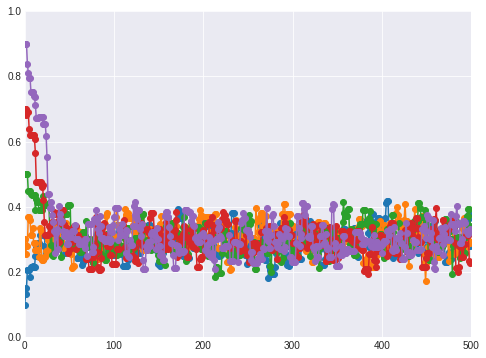

In [15]:
plt.figure(figsize=(8, 6))

for chain in chains:
    plt.plot(chain, '-o')
    
plt.xlim([0, niters])
plt.ylim([0, 1]);

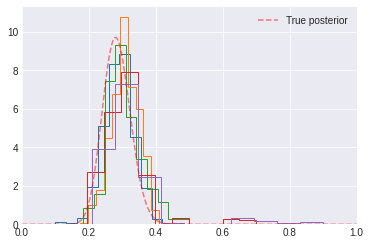

In [16]:
for chain in chains:
  plt.xlim([0,1])
  plt.hist(chain,histtype='step', linewidth=1,density=True)
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')

plt.legend()

# Probabilistic programming languages (PPLs)

### 1st generation: Bugs, WinBugs, Jags, etc.

- Inference engine based on Monte Carlo methods.

- They did not scale to large data samples/high-dimensional models.

### 2nd generation: Infer.net, Factorie, Amidst, etc.

- Inference engine based on message passage algorithms and/or variational
inference methods.

- They did scale to large data samples/high-dimensional models.

- Restricted probabilistic model family (i.e. factor graphs, conjuage exponential family, etc.)

### 3rd generation: Stan, TensorFlow Probability, PyMC3, Pyro, Numpyro, Turing.jl, NIMBLE, Edward, InferPy, etc

- Hamiltonian Monte-Carlo, Black Box Variational Inference, etc

- They did scale to large data samples/high-dimensional models.

- Enable probabilistic models with deep neural networks:
  - Rely on deep learning frameworks (TensorFlow, Pytorch, Theano, etc).
  - Specialized hardware like GPUs, TPUs, etc.
  - Automatic differentiation methods.


## Pyro (www.pyro.ai)

PyRo demo: https://colab.research.google.com/drive/1Wkc8izTsjCrUrNwKKQL4K9uSxDIaPZWp?usp=sharing

In [17]:
!pip install -q --upgrade pyro-ppl torch

In [18]:
import pyro
import torch
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS, HMC

print(pyro.__version__)

1.8.4


## Pyro's dstributions:

https://docs.pyro.ai/en/stable/distributions.html

In [19]:
normal = dist.Normal(0,1)
normal

Normal(loc: 0.0, scale: 1.0)

In [20]:
sample = normal.sample()
sample

tensor(0.6268)

In [21]:
sample = normal.sample(sample_shape=[3,4,5])
print(sample)
print(sample.shape)

tensor([[[-0.4223, -2.7189, -0.9832, -0.0682, -1.5115],
         [-0.6253, -0.6901, -1.9122,  0.0162, -1.7011],
         [ 3.2385,  1.2886, -0.7373, -0.4792, -0.2792],
         [ 1.3821, -0.6459, -0.2887, -0.2134,  1.7973]],

        [[ 0.3191, -0.9647, -0.9471, -1.1906,  0.4123],
         [-0.9863, -0.7400,  0.0915, -1.7202, -0.0730],
         [ 0.7836, -0.1455,  1.2005,  1.0932,  1.6605],
         [ 0.2147, -0.9787, -0.3630,  1.4467, -0.1810]],

        [[-0.4394,  1.3861,  0.8180, -0.0873, -0.1662],
         [-0.7696, -0.0996,  0.8778,  0.3753,  0.5348],
         [-1.4372, -0.5173,  1.0872,  0.7881, -0.3045],
         [ 0.2338, -1.6379, -1.3919, -0.6510, -1.6629]]])
torch.Size([3, 4, 5])


In [22]:
normal.log_prob(sample)

tensor([[[-1.0081, -4.6150, -1.4023, -0.9213, -2.0613],
         [-1.1145, -1.1571, -2.7473, -0.9191, -2.3659],
         [-6.1630, -1.7491, -1.1908, -1.0338, -0.9579],
         [-1.8741, -1.1275, -0.9606, -0.9417, -2.5341]],

        [[-0.9698, -1.3843, -1.3674, -1.6277, -1.0039],
         [-1.4054, -1.1927, -0.9231, -2.3985, -0.9216],
         [-1.2260, -0.9295, -1.6395, -1.5165, -2.2975],
         [-0.9420, -1.3978, -0.9848, -1.9654, -0.9353]],

        [[-1.0155, -1.8795, -1.2535, -0.9227, -0.9327],
         [-1.2151, -0.9239, -1.3042, -0.9894, -1.0619],
         [-1.9517, -1.0527, -1.5099, -1.2295, -0.9653],
         [-0.9463, -2.2602, -1.8876, -1.1308, -2.3016]]])

## Pyro's models:

https://pyro.ai/examples/intro_long.html

Probabilistic models in Pyro are specified as Python functions __model(\*args, \**kwargs)__ that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of __model()__ are encoded via the mapping:

latent random variables $z$ -- _pyro.sample_

observed random variables $x$ -- _pyro.sample_ with the 'obs' keyword argument

learnable parameters $\theta$ -- _pyro.param_

plates -- _pyro.plate_ context managers

Revisiting coin flip using pyro MCMC

In [23]:
def model(data):
    # set prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    prior = dist.Beta(alpha0, beta0)

    # sample z from the prior
    z = pyro.sample("z", prior)

    with pyro.plate("data_plate"):    
        # observe data
        pyro.sample("obs", dist.Bernoulli(z), obs=data)

In [24]:
p = stats.bernoulli.rvs(0.2,size=20)      
data = torch.tensor(p,dtype=float)

In [25]:
data

tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
        0., 0.], dtype=torch.float64)

In [ ]:
kernel = HMC(model) # Hamiltonian Monte Carlo:  Compared to using a Gaussian random walk
                    # proposal distribution in the Metropolis–Hastings algorithm,
                    # Hamiltonian Monte Carlo reduces the correlation between
                    # successive sampled states by proposing moves to distant
                    # states which maintain a high probability of acceptance. 
                    
m = MCMC(kernel, num_samples=1000, num_chains=2)
m.run(data = data)

/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup [0]:  40%|███▉      | 794/2000 [00:12, 68.74it/s, step size=1.17e+00, acc. prob=0.789]

In [ ]:
samples = m.get_samples()
plt.xlim([0,1])
plt.hist(samples['z'],histtype='step', linewidth=1,density=True)

# Approximate posterior estimation: variational inference

Bayesian inference involves characterizing the posterior

\begin{align}
  p(\theta|y,d) = \frac{p(y|\theta,d)p(\theta)}{p(y)},
\end{align}

where $p(\theta|y,d)$ is the posterior, $p(\theta)$ is the prior, $p(y|\theta,d)$ is the likelihood, and $p(y)$ is the evidence. 

Variational inference approximates the Bayesian posterior with a density $q(\theta;\lambda)$, chosen from a parametric family of
densities that is closest to the true posterior in the Kullback-Leibler (KL) divergence sense, namely:

\begin{align}
  \lambda^{\ast} &= \mbox{argmin}_{\lambda}
  KL\left[q(\theta;\lambda)||p(\theta|y)\right] \nonumber
\end{align}

![imageinfo](https://hanveiga.com/vi.png)

The KL divergence between $q$ and $p$ can be written as:

\begin{align}
  KL\left[q(\theta;\lambda)||p(\theta|y)\right] &= \mathbb{E}_{q}\left[\ln q(\theta;\lambda)\right] - \mathbb{E}_{q}\left[\ln p(\theta|y)\right]\\
  &= \mathbb{E}_{q}\left[\ln q(\theta;\lambda)\right] - \mathbb{E}_{q}\left[\ln p(y|\theta)\right] - \mathbb{E}_{q}\left[\ln p(\theta)\right] + \mathbb{E}_{q}\left[\ln p(y)\right]\end{align}

We can rewrite the minimisation above as:
\begin{align}
  \mbox{argmin}_{\lambda}
  KL\left[q(\theta;\lambda)||p(\theta|y)\right] &= \mbox{argmax}_{\lambda} \mathbb{E}_{q}\left[\ln p(y|\theta)\right] + \mathbb{E}_{q}\left[\ln p(\theta)\right] - \mathbb{E}_{q}\left[\ln q(\theta;\lambda)\right]
\end{align}
to arrive at the well-known evidence lower bound (ELBO).

In variational inference, we seek parameters $\lambda$ that maximizes the ELBO, considering a distribution belonging to some fixed family of distributions. We turn the problem of computing the posterior into an optimisation problem.

In [ ]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

# in addition to model, we must define the "guide", which describes the
# variational inference family of distributions

# https://pyro.ai/examples/svi_part_i.html

def guide(data):
    # register the two variational parameters with Pyro.
    # family of distributions: Beta distributions

    a_q = pyro.param("a_q", torch.tensor(10.0),
                        constraint=constraints.positive)
    b_q = pyro.param("b_q", torch.tensor(10.0),
                        constraint=constraints.positive)
    
    # sample coin parameter from the distribution Beta(a_q, b_q)
    pyro.sample("z", dist.Beta(a_q, b_q))

In [ ]:
# set up the optimizer
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 5000

# do gradient steps
for step in range(n_steps):
    svi.step(data)


In [ ]:
# grab the learned variational parameters
a_q = pyro.param("a_q").item()
b_q = pyro.param("b_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = a_q / (a_q + b_q)
# compute inferred standard deviation
factor = b_q / (a_q * (1.0 + a_q + b_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

In [ ]:
# Approximated posterior
var_dist = dist.Beta(a_q,b_q)
samples = var_dist.sample([5000])

plt.hist(samples.detach().numpy(),histtype='step', linewidth=1,density=True)
plt.xlim([0,1])

# Using Pyro to make a Bayesian Linear Regression

Consider the following model for the data:

$ y = f(x) + \epsilon \quad \epsilon \sim \mathcal{N}(0,\sigma)$

For a "deterministic" linear model, we consider:

$f(x) = w^T x + b \quad \vec{w},\vec{x}\in\mathbb{R}^n, \quad b\in\mathbb{R}$

What if the coefficients of the linear regression are themselves random variables, that we want to characterise? I.e.:

$f(x) = w^T x + b \quad \vec{x}\in\mathbb{R}^n, \quad \vec{w}\sim \mathcal{D}_1 \quad b \sim \mathcal{D}_2$


Below we use a tutorial adapted from https://pyro.ai/examples/intro_long.html, in a simplified problem (scalar regression).

In [ ]:
import numpy as np

# Generate Data
nData = 100
X = np.linspace(0,1,nData)

Y = 2.0*X + 1.0 + np.random.normal(0,0.1,size=nData)

X = torch.Tensor(X.reshape(nData,1))
y = torch.Tensor(Y)

In [ ]:
plt.plot(X,Y,marker='.',ls='None')

In [ ]:
from torch import nn
from pyro.nn import PyroModule

# Regression model
# scalar regression model
linear_reg_model = PyroModule[nn.Linear](1, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.001)
num_iterations = 6000 

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(X).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

In [ ]:
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

y_pred = linear_reg_model(X).squeeze(-1)
print(r2_score(y,y_pred.detach().numpy()))

y_pred = linear_reg_model(X).squeeze(-1)

In [ ]:
fit = linear_reg_model(X).detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.plot(X, y, "o")
plt.plot(X, fit, ls='None',marker='.')
plt.xlabel("x")
plt.ylabel("Y")

In [ ]:
from pyro.nn import PyroSample
import torch.distributions.constraints as constraints

pyro.clear_param_store()

def model(X, Y=None):

    bias = pyro.sample("bias", dist.Normal(0., 1.))
    weight1 = pyro.sample("weight1", dist.Normal(0., 1.0))
    sigma = pyro.sample("noise", dist.Uniform(0., 10.))

    mean = bias + weight1 * X

    with pyro.plate("data", len(X)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=Y)

def custom_guide(X, Y=None):
    # parameters for the distribution of the bias random variable
    # we assume bias is normally distributed
    b_loc = pyro.param('bias_loc', lambda: torch.tensor(0.))
    b_scale = pyro.param('bias_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    

    # parameters for the distribution of the noise random variable
    # we assume noise is normally distributed with 0 mean, thus we only learn noise
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    
    # parameters for the distribution of the weight random variable
    # we assume weight is normally distributed
    weights_loc = pyro.param('weights_loc', lambda: torch.tensor(1.))
    weights_scale = pyro.param('weights_scale', lambda: torch.tensor(1.),
                               constraint=constraints.positive)
    

    b = pyro.sample("bias", dist.Normal(b_loc, b_scale))
    b_a = pyro.sample("weight1", dist.Normal(weights_loc, weights_scale))
    sigma = pyro.sample("noise", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"bias": b, "weight1": b_a, "noise": sigma}

adam = pyro.optim.Adam({"lr": 0.005})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

losses = []

for step in range(3000):  # Consider running for more steps.
    loss = svi.step(X.squeeze(-1), y) # this is just a fix for the dimension :c
    losses.append(loss)
    if step % 100 == 0:
        print(f"Elbo loss: {loss}")

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

In [ ]:
X=X.squeeze(-1)

fit = pyro.param('weights_loc').data.cpu().numpy()*X.data.cpu().numpy() +np.ones(nData)*pyro.param('bias_loc').data.cpu().numpy()
fit1 = (pyro.param('weights_loc').data.cpu().numpy()+pyro.param('weights_scale').data.cpu().numpy())*X.data.cpu().numpy() \
+np.ones(nData)*(pyro.param('bias_loc').data.cpu().numpy()+pyro.param('bias_scale').data.cpu().numpy())
fit2 = (pyro.param('weights_loc').data.cpu().numpy()-pyro.param('weights_scale').data.cpu().numpy())*X.data.cpu().numpy()\
 +np.ones(nData)*(pyro.param('bias_loc').data.cpu().numpy()-pyro.param('bias_scale').data.cpu().numpy())

plt.figure(figsize=(6, 6))
plt.plot(X, y, "o")
plt.plot(X, fit)
plt.plot(X, fit1, alpha=0.6,color='blue')
plt.plot(X, fit2, alpha=0.6,color='blue')

In [ ]:
# Automatic guide
auto_guide = pyro.infer.autoguide.AutoNormal(model)

In [ ]:
adam = pyro.optim.Adam({"lr": 0.005})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []

for step in range(3000):  # Consider running for more steps.
    loss = svi.step(X.squeeze(-1), y) # this is just a fix for the dimension :c
    losses.append(loss)
    if step % 100 == 0:
        print(f"Elbo loss: {loss}")

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

In [ ]:
fit = pyro.param('AutoNormal.locs.weight1').data.cpu().numpy()*X.data.cpu().numpy() +np.ones(nData)*pyro.param('AutoNormal.locs.bias').data.cpu().numpy()
fit1 = (pyro.param('AutoNormal.locs.weight1').data.cpu().numpy()+pyro.param('AutoNormal.scales.weight1').data.cpu().numpy())*X.data.cpu().numpy() \
+np.ones(nData)*(pyro.param('AutoNormal.locs.bias').data.cpu().numpy()+pyro.param('AutoNormal.scales.bias').data.cpu().numpy())
fit2 = (pyro.param('AutoNormal.locs.weight1').data.cpu().numpy()-pyro.param('AutoNormal.scales.weight1').data.cpu().numpy())*X.data.cpu().numpy()\
 +np.ones(nData)*(pyro.param('AutoNormal.locs.bias').data.cpu().numpy()-pyro.param('AutoNormal.scales.bias').data.cpu().numpy())


plt.figure(figsize=(6, 6))
plt.plot(X, y, "o")
plt.plot(X, fit)
plt.plot(X, fit1, alpha=0.6,color='blue')
plt.plot(X, fit2, alpha=0.6,color='blue')